# AnoGAN
<hr/>

#### Parameter 조정
- epochs: 높을 때 보다 낮을 때가 좋았으며, 100 과 64 비교 시 structure 모양에 따라 각각 anomaly score의 차이가 다름
- learning_rate: 1e-5 => 2e-1 (큰 차이는 없지만 2e-1)이 조금 더 나음
- learning_G_per_D: 1 일 때가 가장 좋은 결과 값이 나옴
- 마지막 test 사진은, 정확도가 떨어짐
- 구조가 복잡한 건 잘 잡히지 않음

#### parameter
- 2020.08.16
> latent_size = 100  
> workers = 4 
> img_size = 64  
> channel = 1  
> epochs = 100  
> batch_size = 64  
> **learning_rate = 2e-1  
> learning_G_per_D = 1**


# Module

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
import os
import numpy as np

import torchvision.datasets as dataset
import torchvision.transforms as transforms
import torchvision.utils as vutils

# Graph & Animation
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Hyper Parameter

In [2]:
latent_size = 100 # z벡터의 잠재공간(latent space)의 크기
workers = 4 # 0일때, 약 20% 사용 4일 경우 메모리 100%
img_size = 64
channel = 1
epochs = 100
batch_size = 64
learning_rate = 2e-1

# Data and Device

In [3]:
# 이미지 경로, 이미지들 리사이즈 및 텐서형태로 만들기
# data_root = "../../dataset/train"
data_root = "../../../OhSeHyeon/source/dataset/aug_train"

data_set = dataset.ImageFolder(root = data_root,
                           transform = transforms.Compose([
                                  #transforms.Resize(img_size),
                                  transforms.CenterCrop(img_size),
                                  torchvision.transforms.Grayscale(channel),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,),(0.5,))
                              ]))

print("size of dataset :", len(data_set))

# 배치로 나누고 셔플하기
data_loader = torch.utils.data.DataLoader(data_set, batch_size = batch_size,
                                         shuffle = True, num_workers = workers, drop_last=True)

# Device setting (GPU or CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("device :", device)

size of dataset : 920
device : cuda:0


# Model

In [6]:
# Generative Adversarial Networks Model

# === Generator 모델 ===
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        
        # Batch Normalization 유무에 따른 G_block 정의
        def G_block(in_features, out_features, FIRST=True):
            if FIRST:
                block = [
                    nn.ConvTranspose2d(in_features, out_features, 4, 1, 0, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ReLU()
                ]
            else:
                block = [
                    nn.ConvTranspose2d(in_features, out_features, 4, 2, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ReLU()
                ]
            return block
        
        
        # ======================= 픽셀 분포 생성 layer ======================= 
        self.G_gen_distribution = nn.Sequential(
            # ------ input is latent_size 100 ------ 
            *G_block(latent_size, img_size*8, FIRST=True),
            # ------ state size is 512x4x4 ------ 
            *G_block(img_size*8, img_size*4, FIRST=False),
            # ------ state size is 256x8x8 ------ 
            *G_block(img_size*4, img_size*2, FIRST=False),
            # ------ state size is 128x16x16 ------ 
            *G_block(img_size*2, img_size, FIRST=False),
        )
        
        # =================== 가짜 이미지 생성 layer =================== 
        self.G_gen_fake_img = nn.Sequential(
            # ------ state size is 64x32x32 ------ 
            nn.ConvTranspose2d(img_size, 1 , 4, 2, 1, bias=False),
            nn.Tanh() # 픽셀값의 범위 : -1 ~ 1로 두기 위해서
            # ------ state size is 1x64x64 ------ 
        )
    
    def forward(self, input):
        distribution = self.G_gen_distribution(input)
        fake_img = self.G_gen_fake_img(distribution)
        
        return fake_img


# === Discriminator 모델 ===
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        # Batch Normalization 유무에 따른 D_block 정의
        def D_block(in_features, out_features, BN=True):
            if BN:
                block = [
                    nn.Conv2d(in_features, out_features, 4, 2, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.LeakyReLU(0.2, inplace=True)
                ]
            else:
                block = [
                    nn.Conv2d(in_features, out_features, 4, 2, 1, bias=False),
                    nn.LeakyReLU(0.2, inplace=True)
                ]
            return block
        
        
        # ============== Feature 추출 layer ==============
        self.D_extract_feature = nn.Sequential(
            # ------ input is 1 x 64 x 64 ------ 
            *D_block(channel, img_size, BN=False),
            # ------ state is 64 x 32 x 32 ------ 
            *D_block(img_size, img_size*2, BN=True),
            # ------ state is 128 x 16 x 16 ------ 
            *D_block(img_size*2, img_size*4, BN=True),
            # ------ state is 256 x 8 x 8 ------ 
            *D_block(img_size*4, img_size*8, BN=True)
        )
        
        # ===================== 이진 분류 layer =====================
        self.D_classification = nn.Sequential(        
            # ------- state size 512x4x4 ------- 
            nn.Conv2d(img_size*8, channel, 4, 1, 0, bias=False),
            #nn.Linear(fms*8*4*4, 1, bias=False),
            nn.Sigmoid()        
        )
        
    def forward(self, input):
        feature = self.D_extract_feature(input)
        classification = self.D_classification(feature)
        
        return classification, feature

# Loss & Optim

In [7]:
# G and D 무게 초기화, classname 에 찾는 name가 없다면 -1 ,
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# D,G 네트워크 모델 객체 선언
D = Discriminator().to(device)
G = Generator().to(device)

# weight initialize/ nn.Module 클래스 안에 apply 함수가 정의되 있음, 각 함수들에 다 적용 하게한다
D.apply(weights_init)
G.apply(weights_init)

# Binary cross entropy loss and optimizer
criterion = nn.BCELoss()

# latent vector에 배치 사이즈 64를 적용
# 학습한 G로 새로운 것 만들어서 결과 확인 할때 사용
noise_z = torch.randn(img_size, latent_size, 1, 1, device = device)

# D와 G에 대해 두가지 최적화 설정
D_optimizer = torch.optim.Adam(D.parameters(), lr = learning_rate, betas=(0.5,0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr = learning_rate, betas=(0.5,0.999))

#print(D)
#print(G)

def reset_grad():
    D_optimizer.zero_grad()
    G_optimizer.zero_grad()

---

# Train

In [8]:
img_list = []
G_losses = []
D_losses = []
iters = 0

def train(epoch, learning_G_per_D):
    global epochs
    global iters
    
    # 인덱스 0부터 세기 시작
    # data[0].size():64x1x64x64(image) / data[1].size():64(label)
    for i,data in enumerate(data_loader,0):
        
        # Train Discriminator
        real_img = data[0].to(device) # image size: 64x1x64x64(batch, channel, width, height)
        b_size = real_img.size(0) # b_size = 64
        real_labels = torch.ones(b_size, 1).to(device)
        fake_labels = torch.zeros(b_size, 1).to(device)
        
        # (--------------------------real-----------------------------)
        real_classification, _ = D(real_img) # output = D(x)
        real_loss = criterion(real_classification, real_labels) # D(x)=1일 때의 loss
        real_score = real_classification
        D_x = real_score.mean().item() 
            
        # (--------------------------fake-----------------------------)
        z = torch.randn(b_size, latent_size, 1, 1).to(device) # z size :64x100x1x1
        fake_img = G(z)
        fake_classification, _ = D(fake_img) # output = D(G(z))
        fake_loss = criterion(fake_classification, fake_labels) # D(G(z))=0일 때의 loss
        fake_score = fake_classification
        D_G_z1 = fake_score.mean().item()

        # (------------------Backprop and optimize---------------------)
        D_loss = real_loss + fake_loss 
        reset_grad()
        D_loss.backward()
        D_optimizer.step() # D(x)=1, D(G(z))=0이어야 D가 최적

        
        # Train Generater
        #z = torch.randn(b_size,latent_size,1,1,device=device) # z size :64x100x1x1
        for k in range(learning_G_per_D):
            fake_img = G(z)
            fake_classification, _ = D(fake_img)  # output : D(G(z))
            D_G_z2 = fake_classification.mean().item()
            G_loss = criterion(fake_classification, real_labels) # D(G(z))=1일 때의 loss=log(D(G(z)))

            # (------------------Backprop and optimize---------------------)
            reset_grad()
            G_loss.backward()
            G_optimizer.step() # D(G(z))=1 이어야 G가 최적
            # ==> D(G(z))의 값이 0.5로 수렴해야 한다.
        
        
        # print
        print('[%d/%d][%d/%d]\n- D_loss : %.4f / G_loss : %.4f\n- D(x) : %.4f / D(G(z1)) : %.4f / D(G(z2)) : %.4f' 
                   %(epoch+1, epochs, i, len(data_loader),D_loss.item(),
                     G_loss.item(),D_x,D_G_z1,D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(G_loss.item())
        D_losses.append(D_loss.item())
        
        #Check how the generator is doing by saving G's output on noise_z
        if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(data_loader)-1)):
            with torch.no_grad():
                fake = G(noise_z).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
        
#torch.save(G.state_dict(), 'G.ckpt')
#torch.save(D.state_dict(), 'D.ckpt')

In [9]:
for epoch in range(epochs):
    train(epoch, learning_G_per_D = 20)

/home/piai/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[1/100][0/14]
- D_loss : 1.3853 / G_loss : 0.0000
- D(x) : 0.4997 / D(G(z1)) : 0.4991 / D(G(z2)) : 1.0000
[1/100][1/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[1/100][2/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[1/100][3/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[1/100][4/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[1/100][5/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[1/100][6/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[1/100][7/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[1/100][8/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[1/100][9/14]
- D_loss : 100.0

[6/100][6/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[6/100][7/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[6/100][8/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[6/100][9/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[6/100][10/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[6/100][11/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[6/100][12/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[6/100][13/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[7/100][0/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[7/100][1/14]
- D_loss :

[11/100][12/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[11/100][13/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[12/100][0/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[12/100][1/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[12/100][2/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[12/100][3/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[12/100][4/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[12/100][5/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[12/100][6/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[12/100][7/14]
- 

[17/100][3/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[17/100][4/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[17/100][5/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[17/100][6/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[17/100][7/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[17/100][8/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[17/100][9/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[17/100][10/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[17/100][11/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[17/100][12/14]
-

[22/100][8/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[22/100][9/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[22/100][10/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[22/100][11/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[22/100][12/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[22/100][13/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[23/100][0/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[23/100][1/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[23/100][2/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[23/100][3/14]


[27/100][13/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[28/100][0/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[28/100][1/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[28/100][2/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[28/100][3/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[28/100][4/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[28/100][5/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[28/100][6/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[28/100][7/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[28/100][8/14]
- D

[33/100][4/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[33/100][5/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[33/100][6/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[33/100][7/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[33/100][8/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[33/100][9/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[33/100][10/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[33/100][11/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[33/100][12/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[33/100][13/14]


[38/100][9/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[38/100][10/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[38/100][11/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[38/100][12/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[38/100][13/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[39/100][0/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[39/100][1/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[39/100][2/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[39/100][3/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[39/100][4/14]


[44/100][0/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[44/100][1/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[44/100][2/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[44/100][3/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[44/100][4/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[44/100][5/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[44/100][6/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[44/100][7/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[44/100][8/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[44/100][9/14]
- D_

[49/100][5/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[49/100][6/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[49/100][7/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[49/100][8/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[49/100][9/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[49/100][10/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[49/100][11/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[49/100][12/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[49/100][13/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[50/100][0/14]


[54/100][10/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[54/100][11/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[54/100][12/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[54/100][13/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[55/100][0/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[55/100][1/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[55/100][2/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[55/100][3/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[55/100][4/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[55/100][5/14]


[60/100][1/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[60/100][2/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[60/100][3/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[60/100][4/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[60/100][5/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[60/100][6/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[60/100][7/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[60/100][8/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[60/100][9/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[60/100][10/14]
- D

[65/100][6/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[65/100][7/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[65/100][8/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[65/100][9/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[65/100][10/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[65/100][11/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[65/100][12/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[65/100][13/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[66/100][0/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[66/100][1/14]


[70/100][11/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[70/100][12/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[70/100][13/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[71/100][0/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[71/100][1/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[71/100][2/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[71/100][3/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[71/100][4/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[71/100][5/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[71/100][6/14]
-

[76/100][2/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[76/100][3/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[76/100][4/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[76/100][5/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[76/100][6/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[76/100][7/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[76/100][8/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[76/100][9/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[76/100][10/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[76/100][11/14]
- 

[81/100][7/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[81/100][8/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[81/100][9/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[81/100][10/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[81/100][11/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[81/100][12/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[81/100][13/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[82/100][0/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[82/100][1/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[82/100][2/14]


[86/100][12/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[86/100][13/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[87/100][0/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[87/100][1/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[87/100][2/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[87/100][3/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[87/100][4/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[87/100][5/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[87/100][6/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[87/100][7/14]
- 

[92/100][3/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[92/100][4/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[92/100][5/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[92/100][6/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[92/100][7/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[92/100][8/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[92/100][9/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[92/100][10/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[92/100][11/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[92/100][12/14]
-

[97/100][8/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[97/100][9/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[97/100][10/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[97/100][11/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[97/100][12/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[97/100][13/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[98/100][0/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[98/100][1/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[98/100][2/14]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x) : 1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[98/100][3/14]


# Graph

In [10]:
def plot_train_loss():
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(G_losses, label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

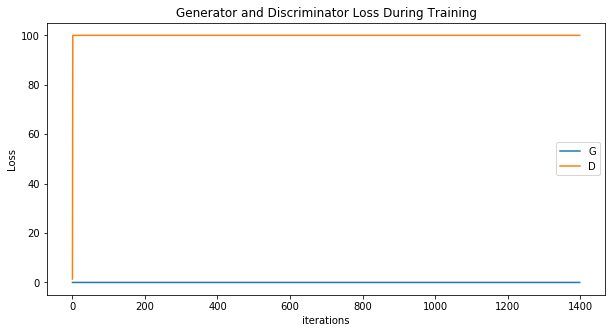

In [11]:
plot_train_loss()

# Animation

In [12]:
def animate_gen_imgs():
    fig = plt.figure(figsize=(8,8))
    plt.axis("off")
    
    ims=[[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
    ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
    HTML(ani.to_jshtml())

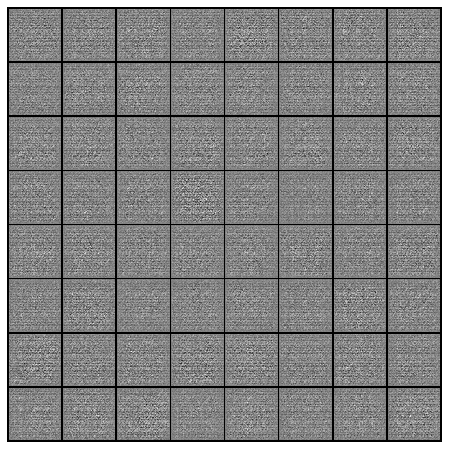

In [13]:
animate_gen_imgs()

# Anomaly Loss

In [14]:
latent_vector = torch.randn(1, latent_size, 1, 1, device = device, requires_grad=True)

def Anomaly_loss(Test_Data, G_Data, Lambda=0.1):
    
    _, Test_Data_feature =  D(Test_Data)
    _, G_Data_feature    =  D(G_Data)
    residual_loss        =  torch.sum(torch.abs(Test_Data - G_Data))
    discrimination_loss  =  torch.sum(torch.abs(Test_Data_feature - G_Data_feature))
    ano_loss             =  (1-Lambda)*residual_loss + Lambda*discrimination_loss
    
    return ano_loss

z_optimizer = torch.optim.Adam([latent_vector],lr=0.01,betas=(0.5, 0.999))


test_data_root = "../../../OhSeHyeon/source/dataset/test/test_Ti64"
test_data_set = dataset.ImageFolder(root = test_data_root,
                           transform = transforms.Compose([
                                  transforms.Resize(img_size),
                                  transforms.CenterCrop(img_size),
                                  torchvision.transforms.Grayscale(channel),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,),(0.5,))
                              ]))


# 배치로 나누고 셔플하기
test_data_loader = torch.utils.data.DataLoader(test_data_set, batch_size = 1,
                                              shuffle = False, num_workers = workers)

# Train Latent Space Z

In [15]:
latent_space = []
auc=[]

def train_latent_space():
    global latent_space
    global auc
    
    for i,data in enumerate(test_data_loader,0):
        test_img = data[0].to(device)
        print("picture ", i+1)
        for step in range(401):

            G_Data   = G(latent_vector)
            ano_loss = Anomaly_loss(test_img, G_Data)

            z_optimizer.zero_grad()

            # residual loss, dicriminator loss 의 그래디언트를 학습 가능한 weight에 독립적으로 반역하기 위해서
            # 한쪽 로스를 업데이트하면 그래디언트가 해제되서 
            ano_loss.backward(retain_graph = True)

            z_optimizer.step()

            if step%200 == 0:

                loss   = ano_loss.item()
                noises = torch.sum(latent_vector).item()
                print("[%d]\t Ano_loss : %.4f  Sum_of_z : %.4f" %(step,loss,noises))
                if step==400:
                    latent_space.append(latent_vector.cpu().data.numpy())
                    if loss>500:
                        auc.append(1)
                    else :
                        auc.append(0)

In [16]:
train_latent_space()

latent_space = np.array(latent_space)
latent_space = torch.Tensor(latent_space).to(device)

picture  1
[0]	 Ano_loss : 960.4281  Sum_of_z : -16.3125
[200]	 Ano_loss : 936.9539  Sum_of_z : -11.8645
[400]	 Ano_loss : 936.0629  Sum_of_z : -9.7837
picture  2
[0]	 Ano_loss : 1584.2388  Sum_of_z : -9.2128
[200]	 Ano_loss : 1562.2952  Sum_of_z : 7.9795
[400]	 Ano_loss : 1559.9160  Sum_of_z : 15.5673
picture  3
[0]	 Ano_loss : 1415.6688  Sum_of_z : 15.2886
[200]	 Ano_loss : 1384.9871  Sum_of_z : 8.2910
[400]	 Ano_loss : 1383.9291  Sum_of_z : 10.8900
picture  4
[0]	 Ano_loss : 1516.0389  Sum_of_z : 11.5141
[200]	 Ano_loss : 1497.7277  Sum_of_z : 15.8431
[400]	 Ano_loss : 1497.1036  Sum_of_z : 14.1861
picture  5
[0]	 Ano_loss : 1473.1315  Sum_of_z : 14.1474
[200]	 Ano_loss : 1439.0364  Sum_of_z : 15.2321
[400]	 Ano_loss : 1437.6401  Sum_of_z : 13.9207
picture  6
[0]	 Ano_loss : 1569.4869  Sum_of_z : 14.1694
[200]	 Ano_loss : 1535.9402  Sum_of_z : 10.7598
[400]	 Ano_loss : 1534.5271  Sum_of_z : 13.0013
picture  7
[0]	 Ano_loss : 587.9418  Sum_of_z : 13.0008
[200]	 Ano_loss : 529.0028  S

# Similar Z , Ano_Score and Segementation

In [17]:
def count_el_not_0(diff_img):
    count_el_not_0 = 0
    
    col_size = diff_img.shape[0]
    row_size = diff_img.shape[1]
    
    #print(col_size, row_size)
    
    for col in range(col_size):
        for row in range(row_size):
            if diff_img[col][row] != 0:
                count_el_not_0 += 1
                
    return count_el_not_0

In [18]:
diff_cnts = []

def compare_imgs(real_img, generated_img,i, reverse=False, threshold=50):
    score = Anomaly_loss(real_img, generated_img)
    score = round(score.item(), 2)
    
    real_img = real_img.cpu().data.numpy().reshape(img_size, img_size) * 255
    generated_img = generated_img.cpu().data.numpy().reshape(img_size, img_size) * 255
    negative = np.zeros_like(real_img)
    
    if not reverse:
        diff_img = real_img - generated_img
    else:
        diff_img = generated_img - real_img
    diff_img[diff_img <= threshold] = 0
    # 분율 추출
    diff_cnts.append(count_el_not_0(diff_img))
    
    
    anomaly_img = np.zeros(shape=(img_size, img_size, 3))
    anomaly_img[:, :, 0] = real_img - diff_img
    anomaly_img[:, :, 1] = real_img - diff_img
    anomaly_img[:, :, 2] = real_img - diff_img
    anomaly_img[:, :, 0] = anomaly_img[:,:,0] + diff_img
    anomaly_img = anomaly_img.astype(np.uint8)
    
    
    fig, plots = plt.subplots(1, 4)
    if auc[i] == 0:
        fig.suptitle(f'Normal - (anomaly score: {score:.4})')
    else :
        fig.suptitle(f'Anomaly - (anomaly score: {score:.4})')
    
    fig.set_figwidth(9)
    fig.set_tight_layout(True)
    plots = plots.reshape(-1)
    plots[0].imshow(real_img, cmap='gray', label = "real")
    plots[1].imshow(generated_img, cmap='gray')
    plots[2].imshow(diff_img, cmap='gray')
    plots[3].imshow(anomaly_img)
    
    plots[0].set_title('real')
    plots[1].set_title('generated')
    plots[2].set_title('difference')
    plots[3].set_title('Anomaly Detection')

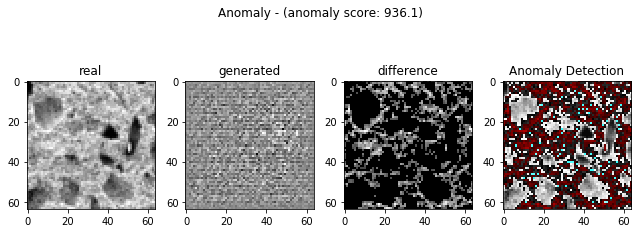

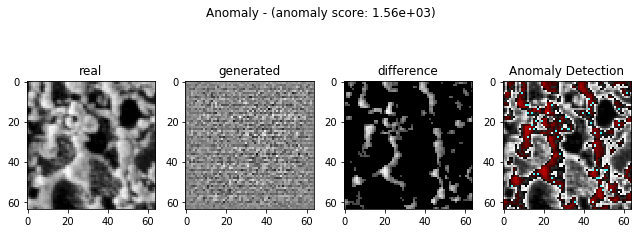

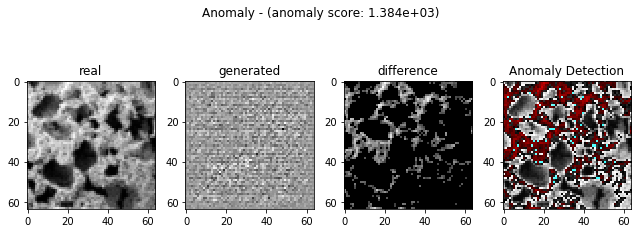

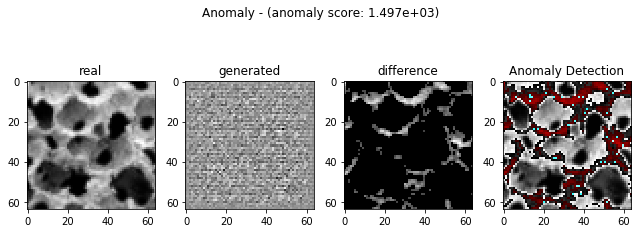

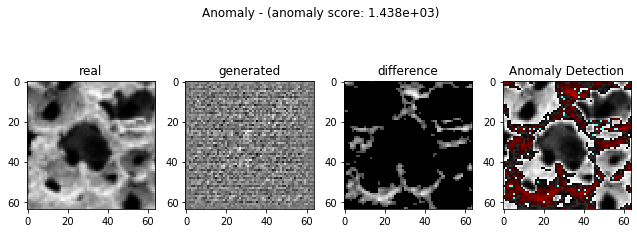

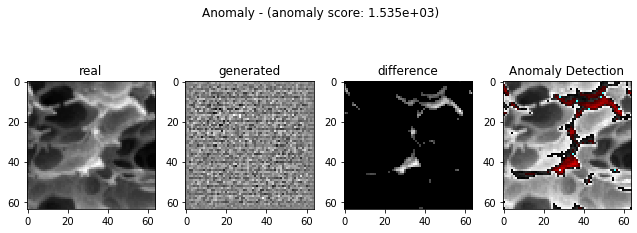

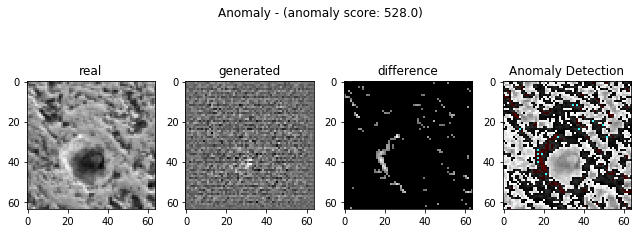

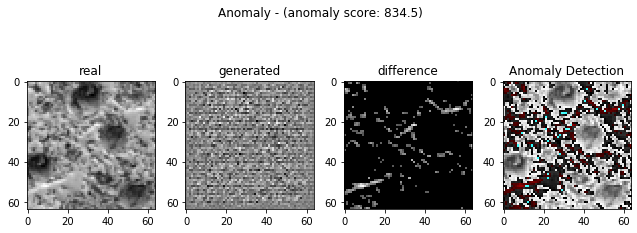

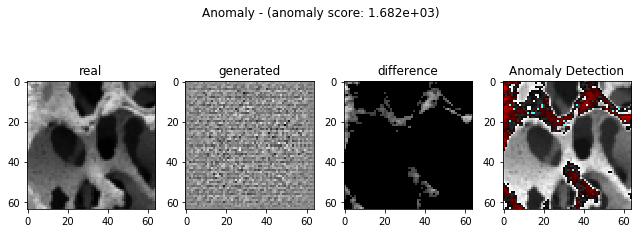

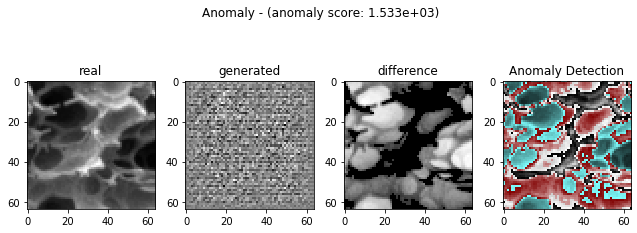

In [19]:
vali_label = [0,0,0,0,0,1,1,1,1,1,1]

for i,data in enumerate(test_data_loader,0):
    test_img = data[0].to(device)

    #for i in range(len(latent_space)):
    update_z = latent_space[i]
    R_img = test_img
    G_img = G(update_z).to(device)
    
    if i in [9]:
        compare_imgs(R_img, G_img,i,reverse = True, threshold = 50)
    else:
        compare_imgs(R_img, G_img,i,reverse = False, threshold = 50)

# 분율 측정

In [20]:
diff_cnts = np.array(diff_cnts)

diff_fraction = diff_cnts / img_size ** 2

print(diff_fraction)

[0.35986328 0.20996094 0.24951172 0.18676758 0.21850586 0.06542969
 0.04711914 0.09863281 0.1237793  0.70239258]


# AnoGAN 성능 확인: 상대밀도

In [21]:
Ti64_density = 4.43

Ti64_rel_densitys = np.array([])

Ti64_rel_densitys = diff_fraction * Ti64_density

print(Ti64_rel_densitys)

[1.59419434 0.93012695 1.10533691 0.82738037 0.96798096 0.28985352
 0.20873779 0.43694336 0.54834229 3.11159912]


### 분율 평균

In [22]:
# 상대 밀도 평균
print(sum(Ti64_rel_densitys)/len(Ti64_rel_densitys))

1.0020495605468749


In [23]:
# 분율 평균
print(sum(diff_fraction)/len(diff_fraction))

0.2261962890625
